# 3. Third Version: Encoding 변화
- 장르: Multi-Hot -> FlixPatrol 사이트 참조하여 각 장르의 점수의 평균 계산
- 제작 국가: Label -> Target encoding(PCA평균값)

In [73]:
# 모듈 불러오기
import pandas as pd
import numpy as np
import re
import ast

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


from sklearn.model_selection import learning_curve

In [74]:
# 데이터 불러오기
df = pd.read_excel('../data/file/ml_all.xlsx', index_col=0)

## 01-1. 제작 국가 인코딩 바꾸기

In [75]:
# 각 범주(나라)의 타겟 변수(여기서는 PCA 평균) 계산
country_means = df.groupby('production_country')['PCA'].mean()

# 타겟 인코딩 적용
df['production_country_encoded'] = df['production_country'].map(country_means)

In [76]:
print(country_means)

production_country
남아프리카공화국    0.309786
네덜란드       -1.647491
노르웨이        0.897731
뉴질랜드        0.630142
대만         -0.142808
대한민국       -0.361577
덴마크         0.907856
독일          1.634898
러시아         0.492123
룩셈부르크       0.387385
멕시코         0.006195
미국          2.452330
벨기에         0.649214
브라질        -0.002870
스웨덴         0.984878
스페인         1.030830
아르헨티나       0.400193
아이슬란드       1.584064
영국          2.804395
이스라엘        1.961163
이탈리아       -0.509365
인도          1.212922
일본         -0.769458
캐나다         1.905836
콜롬비아       -0.417882
태국         -0.786701
터키          0.553134
폴란드        -0.357281
프랑스        -0.563153
핀란드         0.558147
호주          0.970899
Name: PCA, dtype: float64


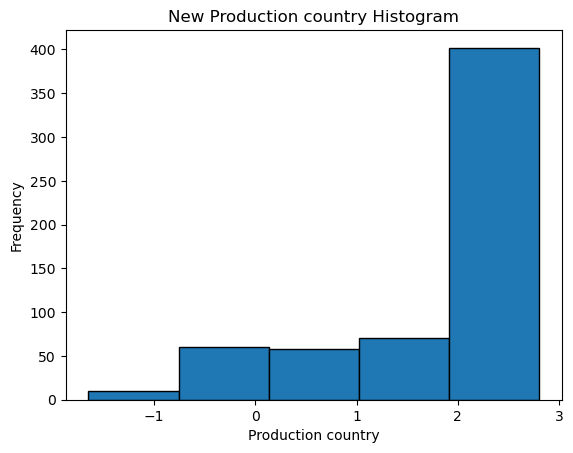

In [77]:
# 히스토그램 그리기
plt.hist(df['production_country_encoded'], bins=5, edgecolor='black')
plt.title('New Production country Histogram')
plt.xlabel('Production country')
plt.ylabel('Frequency')

# 그래프 보여주기
plt.show()

## 01-2. 장르마다 각 값 부여
- 모델의 객관성을 위해 넷플릭스 통계 사이트를 활용함
    - 2023년 넷플릭스 시청 보고서를 참조(FlixPatrol, 'Preferences on Netflix in Q2 2024')

In [78]:
# 넷플릭스 장르 선호도 순위 리스트 (선호도 순서대로 정렬)
genres = [
    '드라마', '코미디', 'SF', '액션', '스릴러', '범죄', '공포', '로맨스', '판타지', '전쟁', '서부', '그 외'
]

# 각 장르에 점수를 선형적으로 할당하여 딕셔너리로 만들기
genre_scores = {genre: 1 - i / (len(genres)) for i, genre in enumerate(genres)}

# '그 외'에 해당되는 장르 리스트
other_genres = ['역사', '가족', '음악', 'Made in Europe', '스포츠']

# 장르 문자열을 받아서 점수를 계산하는 함수

def get_genre_score(genre_str):
    # 장르를 ', '로 분리
    genre_list = genre_str.split(', ')
    
    # '그 외'에 포함된 하위 장르가 있는지 확인
    for genre in genre_list:
        if genre in other_genres:
            return genre_scores['그 외']
    
    # 각 장르의 점수의 평균 계산
    total_score = 0
    count = 0
    for genre in genre_list:
        score = genre_scores.get(genre, genre_scores['그 외'])  # 없는 장르는 '그 외' 점수로 처리
        total_score += score
        count += 1
    
    # 평균 점수 계산
    average_score = total_score / count if count > 0 else 0
    return average_score

# 장르별 점수
df['genre'] = df['genre'].apply(get_genre_score)

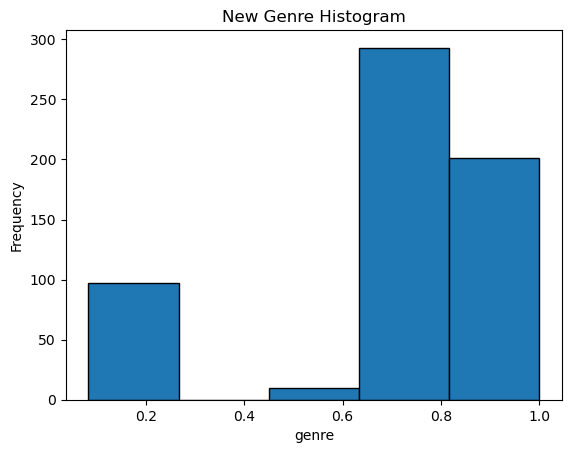

In [79]:
# 히스토그램 그리기
plt.hist(df['genre'], bins=5, edgecolor='black')
plt.title('New Genre Histogram')
plt.xlabel('genre')
plt.ylabel('Frequency')

# 그래프 보여주기
plt.show()

---

## 02-1. Modeling

In [80]:
# 로그 변환 적용 

df['i_s2_rate_cnt'] = np.log1p(df['i_s2_rate_cnt'])  # log(1+x) 변환 사용
df['w_s2_rate_cnt'] = np.log1p(df['w_s2_rate_cnt'])
df['s2_rate_cnt_retention'] = np.log1p(df['s2_rate_cnt_retention'])
df['s1_gap_days'] = np.log1p(df['s1_gap_days'])
df['age_rating'] = np.log1p(df['age_rating'])
df['season_gaps_days'] = np.log1p(df['season_gaps_days'])
df['i_s1_rate_cnt'] = np.log1p(df['i_s1_rate_cnt'])
df['w_s1_rate_cnt'] = np.log1p(df['w_s1_rate_cnt'])
df['s1_rate_cnt_retention'] = np.log1p(df['s1_rate_cnt_retention'])

In [81]:
# Score(y값)
rate = (0.8 * df['i_s2_rate']) + (0.2 * df['w_s2_rate'])
cnt = (0.8 * df['i_s2_rate_cnt']) + (0.2 * df['w_s2_rate_cnt'])
ret = (0.4 * df['s2_rate_retention']) + (0.6 * df['s2_rate_cnt_retention']) *10
total = (0.3 * rate + 0.5 * cnt + 0.2 * ret) *10

# 점수를 데이터프레임에 추가
df['score'] = total

In [82]:
df = df[['runtime','genre','age_rating','production_country_encoded','PCA','genre_len','seson_n','i_s1_rate','i_s1_rate_cnt','s1_rate_retention','s1_rate_cnt_retention','w_s1_rate','w_s1_rate_cnt','s1_gap_days','season_gaps_days','score']]

In [83]:
X = df.drop(['score'], axis=1)  # 'score' 열을 제외한 모든 열 선택
y = df['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [84]:
# DecisionTreeRegressor 모델 초기화
dt_model = DecisionTreeRegressor(random_state=13)
dt_model.fit(X_train, y_train)
predictions = dt_model.predict(X_test)

# 회귀 모델의 성능 평가
dt_mse = mean_squared_error(y_test, predictions)
dt_mae = mean_absolute_error(y_test, predictions)
dt_r2 = r2_score(y_test, predictions)

In [85]:
# RandomForestRegressor 모델 초기화
rf_model = RandomForestRegressor(random_state=13)
rf_model.fit(X_train, y_train)
predictions = rf_model.predict(X_test)

# 회귀 모델의 성능 평가
rf_mse = mean_squared_error(y_test, predictions)
rf_mae = mean_absolute_error(y_test, predictions)
rf_r2 = r2_score(y_test, predictions)

In [86]:
# KNeighborsRegressor 모델 초기화
knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)

# 회귀 모델의 성능 평가
knn_mse = mean_squared_error(y_test, knn_predictions)
knn_mae = mean_absolute_error(y_test, knn_predictions)
knn_r2 = r2_score(y_test, knn_predictions)

In [87]:
# XGBRegressor 모델 초기화
xgb_model = XGBRegressor(random_state=13)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

# 회귀 모델의 성능 평가
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

In [88]:
# AdaBoostRegressor 모델 초기화
ada_model = AdaBoostRegressor(random_state=13)
ada_model.fit(X_train, y_train)
ada_predictions = ada_model.predict(X_test)

# 회귀 모델의 성능 평가
ada_mse = mean_squared_error(y_test, ada_predictions)
ada_mae = mean_absolute_error(y_test, ada_predictions)
ada_r2 = r2_score(y_test, ada_predictions)

In [ ]:
# LGBMRegressor 모델 초기화
lgbm_model = LGBMRegressor(random_state=13)
lgbm_model.fit(X_train, y_train)
lgbm_predictions = lgbm_model.predict(X_test)

# 회귀 모델의 성능 평가
lgbm_mse = mean_squared_error(y_test, lgbm_predictions)
lgbm_mae = mean_absolute_error(y_test, lgbm_predictions)
lgbm_r2 = r2_score(y_test, lgbm_predictions)

In [90]:
# GradientBoostingRegressor 모델 초기화
gbr_model = GradientBoostingRegressor(random_state=13)
gbr_model.fit(X_train, y_train)
gbr_predictions = gbr_model.predict(X_test)

# 회귀 모델의 성능 평가
gbr_mse = mean_squared_error(y_test, gbr_predictions)
gbr_mae = mean_absolute_error(y_test, gbr_predictions)
gbr_r2 = r2_score(y_test, gbr_predictions)

In [91]:
# LinearRegression 모델 초기화
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

# LinearRegression 모델의 성능 평가
lr_mse = mean_squared_error(y_test, lr_predictions)
lr_mae = mean_absolute_error(y_test, lr_predictions)
lr_r2 = r2_score(y_test, lr_predictions)

---

## 02-2. 결과

In [92]:
model_result = pd.DataFrame({
    'MSE': [dt_mse, rf_mse, knn_mse, xgb_mse, ada_mse, lgbm_mse, gbr_mse, lr_mse],
    'MAE': [dt_mae, rf_mae, knn_mae, xgb_mae, ada_mae, lgbm_mae, gbr_mae, lr_mae],
    'R2': [dt_r2, rf_r2, knn_r2, xgb_r2, ada_r2, lgbm_r2, gbr_r2, lr_r2]
}, index=['DecisionTreeRegressor', 'RandomForestRegressor', 'KNeighborsRegressor', 'XGBoostRegressor', 'AdaBoostRegressor', 'LightGBMRegressor', 'GradientBoostingRegressor', 'LinearRegression'])
print(model_result)

                                 MSE       MAE        R2
DecisionTreeRegressor      27.621992  3.875179  0.735646
RandomForestRegressor      11.898751  2.507330  0.886124
KNeighborsRegressor        18.940199  3.502001  0.818734
XGBoostRegressor           12.888833  2.659842  0.876648
AdaBoostRegressor          14.647986  2.890241  0.859812
LightGBMRegressor          10.600179  2.497997  0.898552
GradientBoostingRegressor   9.941281  2.402485  0.904858
LinearRegression            9.598203  2.363427  0.908141


In [93]:
# prompt: 제일 좋은 성능 두가지
print("MSE 기준")
print(model_result.sort_values(by=['MSE'], ascending=True).head(3))
print(" ")

print("MAE 기준")
print(model_result.sort_values(by=['MAE'], ascending=True).head(3))
print(" ")

print("R2 기준")
print(model_result.sort_values(by=['R2'], ascending=False).head(3))

MSE 기준
                                 MSE       MAE        R2
LinearRegression            9.598203  2.363427  0.908141
GradientBoostingRegressor   9.941281  2.402485  0.904858
LightGBMRegressor          10.600179  2.497997  0.898552
 
MAE 기준
                                 MSE       MAE        R2
LinearRegression            9.598203  2.363427  0.908141
GradientBoostingRegressor   9.941281  2.402485  0.904858
LightGBMRegressor          10.600179  2.497997  0.898552
 
R2 기준
                                 MSE       MAE        R2
LinearRegression            9.598203  2.363427  0.908141
GradientBoostingRegressor   9.941281  2.402485  0.904858
LightGBMRegressor          10.600179  2.497997  0.898552


---

## cf. 다중선형회귀

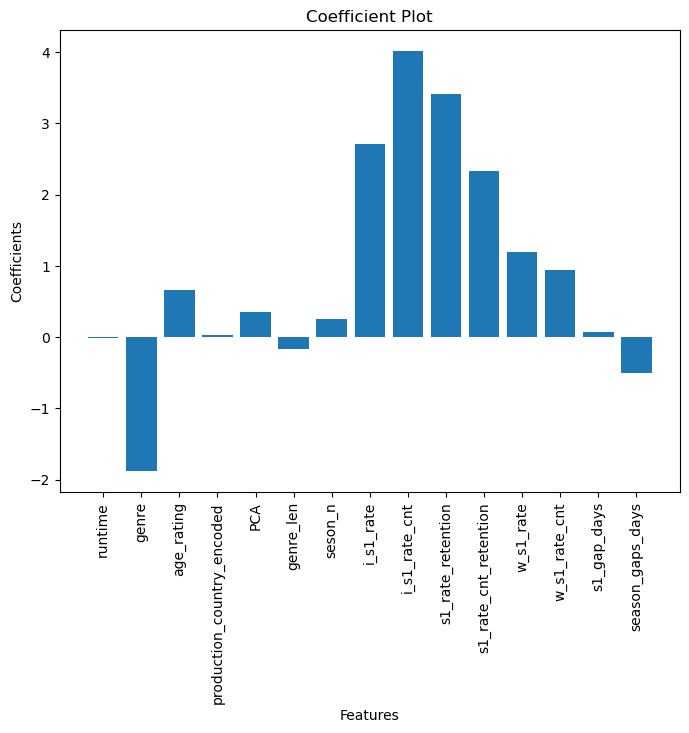

In [94]:
# 모델의 계수를 구합니다.
coefficients = lr_model.coef_
feature_names = df.columns[:-1]  # 마지막 컬럼(Target)을 제외한 컬럼명 사용

# 패러미터 플롯을 생성합니다.
plt.figure(figsize=(8, 6))
plt.bar(feature_names, coefficients)
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('Coefficient Plot')
plt.xticks(rotation=90)  # x축 레이블을 90도 회전
plt.show()

In [95]:
# 중요 특성 선택
X_important_features = df[['i_s1_rate_cnt', 's1_rate_retention','i_s1_rate']]  # 중요 특성 값들로 이루어진 데이터

# 종속 변수 값
y = df['score']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_important_features, y, test_size=0.2, random_state=42)

# 모델 학습
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

# LinearRegression 모델의 성능 평가
lr_mse = mean_squared_error(y_test, lr_predictions)
lr_mae = mean_absolute_error(y_test, lr_predictions)
lr_r2 = r2_score(y_test, lr_predictions)

In [96]:
model_result = pd.DataFrame({'MSE': [lr_mse], 'MAE': [lr_mae], 'R2': [lr_r2]}, index=['LinearRegression'])
print(model_result)

                        MSE       MAE        R2
LinearRegression  13.251991  2.849296  0.867353
